### CNN model of Digit Recognizer using Keras

Hoon Kim (id : KeyboardWarrior6969)

25/12/2020

**1. Introduction**

**2. Data Preparation**

- 2.1 Load Data
- 2.2 Check for Null and missing Values
- 2.3 Normalization
- 2.4 Reshape
- 2.5 Label Encoding
- 2.6 Split Training and Validation Set

**3. CNN Model**

- 3.1 Model Definition
- 3.2 Optimizer And Annealer

**4. Model Performance**

- 4.1 Validation and Training curves
- 4.2 Confusion Matrix
- 4.3 Examples of Inaccurate Predictions

**5. Prediction and Submission of Results**

## 1. Introduction
The aim of this notebook is to showcase a simple CNN build using the keras framework. Only 5 epochs were run utilising the Kaggle CPU architecture. Although starting off as as simple Cnn, further investigation will be undertaken in different notebooks so that eventually the maximum potential architecture will be achived. This will mean:

- The highest possible accuracy
- The lowest cost function value
- no over or underfitting. 


The basic architecture will stay constant. This architecture will consisst of two convolution layers with activation Relu, Dense layer with activation Relu and output layer with activation softmax all whilst using the Adam Optimizer.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers.schedules import ExponentialDecay
sns.set(style = 'white', context= 'notebook', palette = 'deep')

## 2. Data Preparation

### 2.1 Load Data

In [2]:
# Load the data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

### 2.2 Check for null and missing values

In [3]:
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [4]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

No missing value so data will be organized.

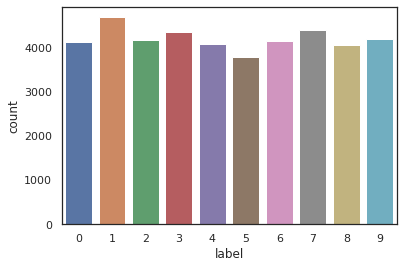

In [5]:
Y_train = train['label'] #extract labels
X_train = train.drop(labels = ['label'], axis = 1) # drop labels
del train # free memory

g = sns.countplot(Y_train)
g

### 2.3 Scaling

A greyscale scaling is utilised to reduce the effect of illumination differences and to increase the efficiency of the training.

In [6]:
X_train = X_train/255.0
test = test/255.0

### 2.3 Reshape

Data is a 784 ( 28^2) column dataframe. CNN requires an image matrix, so the data will be reshaped to a 28 by 28 matrix, with 1 channel since it is black and white.

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test= test.values.reshape(-1,28,28,1)

### 2.5 Label Encoding

Convert labbels to one hot encoding form. so a 2 would be [0,0,1,0,0,0,0,0,0]


In [8]:
Y_train = to_categorical(Y_train,num_classes= 10)

### 2.6 Split training and validation set

In [9]:
# set random seed
random_seed = 2

In [10]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = \
train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Validation data is 10% size of test data

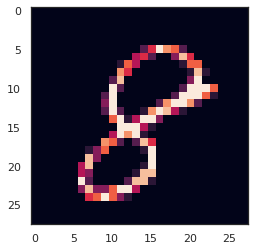

In [11]:
plt.imshow(X_train[0][:,:,0])

## 3.CNN 


### 3.1 Model Definition
The basic model:
2 Convolution layers, 1 dense layer and a final output layer

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation = "softmax"))

### 3.2 Optimizer and Annealer

In [13]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_Accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=5e-7, 
                                            min_lr=0.00001)

In [14]:


# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



epochs = 20 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 128



For the data augmentation :

    - Randomly rotate some training images by 10 degrees
    - Randomly Zoom by 10% some training images
    - Randomly shift images horizontally by 10% of the width
    - Randomly shift images vertically by 10% of the height


In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

In [16]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, callbacks=[learning_rate_reduction]
                              )

Epoch 1/20
295/295 - 10s - loss: 0.2887 - accuracy: 0.9104 - val_loss: 3.4393 - val_accuracy: 0.1538
Epoch 2/20
295/295 - 10s - loss: 0.1132 - accuracy: 0.9649 - val_loss: 0.2318 - val_accuracy: 0.9360
Epoch 3/20
295/295 - 10s - loss: 0.0890 - accuracy: 0.9731 - val_loss: 0.0473 - val_accuracy: 0.9864
Epoch 4/20
295/295 - 9s - loss: 0.0731 - accuracy: 0.9772 - val_loss: 0.0360 - val_accuracy: 0.9893
Epoch 5/20
295/295 - 9s - loss: 0.0664 - accuracy: 0.9803 - val_loss: 0.0743 - val_accuracy: 0.9748
Epoch 6/20
295/295 - 9s - loss: 0.0647 - accuracy: 0.9803 - val_loss: 0.0246 - val_accuracy: 0.9912
Epoch 7/20
295/295 - 11s - loss: 0.0580 - accuracy: 0.9831 - val_loss: 0.0250 - val_accuracy: 0.9921
Epoch 8/20
295/295 - 10s - loss: 0.0534 - accuracy: 0.9840 - val_loss: 0.0243 - val_accuracy: 0.9926
Epoch 9/20
295/295 - 10s - loss: 0.0496 - accuracy: 0.9856 - val_loss: 0.0532 - val_accuracy: 0.9826
Epoch 10/20
295/295 - 10s - loss: 0.0475 - accuracy: 0.9851 - val_loss: 0.0270 - val_accuracy:

## 4. Evaulate The Model

### 4.1 Training and Validation Curves

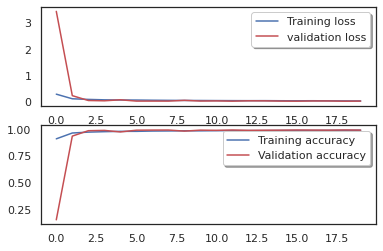

In [17]:


# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



### 4.2 Confusion Matrix

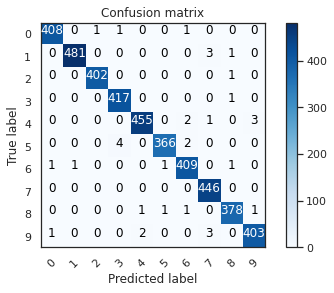

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 



### 4.3 Examples of Inaccurate Predictions

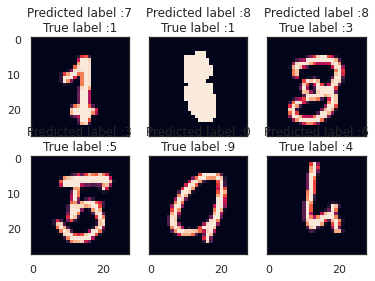

In [19]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 5. Prediction and Submission

In [20]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [21]:


submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

